# Hotel Booking Cancellations Prediction Model

<br><br>
<img src = 'https://www.gannett-cdn.com/presto/2019/05/02/USAT/5b1d7ecc-ce8d-43db-92b9-d7b61c198063-GettyImages-912299740.jpg?width=1320&height=880&fit=crop&format=pjpg&auto=webp'
     height = "600"
     width = "700"/>

<br><br>
<b>I. High Level Outline</b>

Here we are dealing with hotel booking cancellations for a large international hotel chain, and need to build a prediction model that shall help us predict such cancellations in order to take preventive measures to save on revenue loss.

<b> While we are using the available data to predict future cancellations, there are certain qualitative and situation-based reasons behind cancellations which are not easy to predict. It is important to note that the model cannot consider or accomodate for such aspects which lead to cancellation of hotel bookings.</b>

At present, we are looking at the following parameters which are important for our prediction:
- Lead time (how much in advance the booking has been made)
- Arrival date
- Days of stay (weekdays and weekends)
- Travellers types (number of adults, children and babies)
- Meal type
- Country of origin
- Market segment
- Distribution channel
- Repeated guest or not
- Previous cancellations
- Previous bookings not cancelled
- Room type
- Booking changes
- Deposit type
- Agent
- Company
- Days in waiting
- Customer type
- Average Daily Rate
- Required car parkings
- Special requests

<b>II. Brief Background</b>

1. What is the problem?<br>
Many hotels are facing the issue of lat minute booking cacellation 
<br>
<br>
2. Why is it important?<br>
This prediction model is important for the hospitality industry which has seen a decline over the past couple of years, particularly with the Covid-19 pandemic.
Hotels have limited occupancy, and they lose out on potential revenue when they decline new customers on account of being fully booked, and then they see cancellations.
<br>
<br>
3. Who are the key stakeholders?<br>
This predictor model is beneficial for hotels and travel booking agencies.
<br>

<b>III. Cost of incorrect prediction</b>

1. False Positive<br>
In this case, model is predicting that booking will be cancelled but in reality it wont be cancelled<br>
If hotel management is sensing that booking is going to be cancelled then they might find new customer and if the booking is not cancelled eventually then management will have to deal with multiple customers with same room<br>
This can be dealt with easily by keeping the new customers on waitlist instead of directly assigning a room

2. False Negative<br>
In this case, model is predicting that booking will not be cancelled but in reality booking gets cancelled<br>
Here hotel loses potential revenue as the room will be unreserved as the booking get cancelled at the last moment<br>

- False Negatives are more costly for any hotel manegement so I would consider on reducing falls negatives by using recall as performance measure

# 1. Library Imports and Functions

In [386]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import statsmodels.api as sm

from scipy import stats
from scipy.stats import norm
# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)

def summaryStats(X,feature_list):
    q1 = X[feature_list].quantile(0.25)
    q3 = X[feature_list].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             null_values = X[feature_list].isnull().sum(),
                             lower_bound = fence_low,
                             upper_bound = fence_high,
                             outliers_from_IQR = ((X[feature_list] < fence_low) | (X[feature_list] > fence_high)).sum(),
                             outliers_from_Zscore = (np.abs(stats.zscore(X[feature_list])) > 3).sum()
                            ))
    return temp

def target_by_cats(X):
    '''
    This function assumes the input dataframe (X) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean','count']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        df_group['%diff'] = (df_group['diff']/df_group['mean'])*100
        display(df_group)
        
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

def decision_tree_grid_search():
    max_depth = []
    min_impurity_decrease = []
    min_samples_split = []    
    df_output = pd.DataFrame()
    
    df_output['Accuracy'] = gridSearch.cv_results_.get('mean_test_accuracy')
    df_output['Recall'] = gridSearch.cv_results_.get('mean_test_recall')
    df_output['Precision'] = gridSearch.cv_results_.get('mean_test_precision')
    
    for result in gridSearch.cv_results_.get('params'):
        max_depth.append(result.get('max_depth'))
        min_impurity_decrease.append(result.get('min_impurity_decrease'))
        min_samples_split.append(result.get('min_samples_split'))

    df_output['Max Depth'] = max_depth
    df_output['Minimum Impurity Decrease'] = min_impurity_decrease
    df_output['Minimum Samples Split'] = min_samples_split
    df_output['Model'] = 'Decision Tree'
    
    return df_output

def plot_feature_importances(data,model):
    n_features = data.shape[1]
    fig = plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

# 2. Data Reading and initial Analysis

In [283]:
df = pd.read_csv("hotel_bookings.csv")
df.tail()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,NaN,0,Transient,96.1400,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0000,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,NaN,0,Transient,225.4300,0,2
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0000,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0000,NaN,0,Transient,157.7100,0,4
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,NaN,0,Transient,104.4000,0,0
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.0000,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0000,NaN,0,Transient,151.2000,0,2


In [284]:
df.shape

(119390, 30)

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [286]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

**Observation** 

- 119389 records of data so we can cut short the data as we want during data cleaning
- most of the column names are self explainatory. 
    - Market_segment, distribution channel: TA - travel agents, TO - tour Operators
    - agent: agent id
    - company: ID of the company/entity that made the booking or responsible for paying the booking
    - adr: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- Out of 30 features, 10 categorical, 18 numerical and 2 binary 
- is_cancelled is the target variable

|  Impact of features on target|    features                           |
|----------------------|---------------------------------------------------|
| High       | Hotel, stays_in_week_nights, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, assigned_room_type, deposit_type, days_in_waiting_list, country, booking_changes, adr|
| Low     | lead time, arrival_date_week_number, arrival_date_year, arrival_date_month, stays_in_weekend_nights, reserved_room_type, customer_type, children, babies, distribution_channel, total_of_special_requests|
| No impact          | arrival_date_day_of_month, meal, adults, market_segment, agent, company, required_car_parking_spaces|

In [287]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0000,0.3704,0.4829,0.0000,0.0000,0.0000,1.0000,1.0000
lead_time,119390.0000,104.0114,106.8631,0.0000,18.0000,69.0000,160.0000,737.0000
arrival_date_year,119390.0000,2016.1566,0.7075,2015.0000,2016.0000,2016.0000,2017.0000,2017.0000
arrival_date_week_number,119390.0000,27.1652,13.6051,1.0000,16.0000,28.0000,38.0000,53.0000
arrival_date_day_of_month,119390.0000,15.7982,8.7808,1.0000,8.0000,16.0000,23.0000,31.0000
stays_in_weekend_nights,119390.0000,0.9276,0.9986,0.0000,0.0000,1.0000,2.0000,19.0000
stays_in_week_nights,119390.0000,2.5003,1.9083,0.0000,1.0000,2.0000,3.0000,50.0000
adults,119390.0000,1.8564,0.5793,0.0000,2.0000,2.0000,2.0000,55.0000
children,119386.0000,0.1039,0.3986,0.0000,0.0000,0.0000,0.0000,10.0000
babies,119390.0000,0.0079,0.0974,0.0000,0.0000,0.0000,0.0000,10.0000


# 3. Treating with dups,nulls and outliers

In [288]:
#Drop duplicates

In [289]:
print("Records before dropping dups", len(df))
df.drop_duplicates(inplace=True,ignore_index=True)
print("Records after dropping dups", len(df))

Records before dropping dups 119390
Records after dropping dups 87138


We have dropped around 30,000 duplicate records

In [290]:
df_numerical = df.select_dtypes(include=['int64','float64'])
#lets drop is_repeted guest as it is binary column
df_numerical.drop(columns=['is_repeated_guest'], inplace=True)

In [291]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0000,0,0,0,3,NaN,NaN,0,0.0000,0,0
1,0,737,2015,27,1,0,0,2,0.0000,0,0,0,4,NaN,NaN,0,0.0000,0,0
2,0,7,2015,27,1,0,1,1,0.0000,0,0,0,0,NaN,NaN,0,75.0000,0,0
3,0,13,2015,27,1,0,1,1,0.0000,0,0,0,0,304.0000,NaN,0,75.0000,0,0
4,0,14,2015,27,1,0,2,2,0.0000,0,0,0,0,240.0000,NaN,0,98.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87133,0,23,2017,35,30,2,5,2,0.0000,0,0,0,0,394.0000,NaN,0,96.1400,0,0
87134,0,102,2017,35,31,2,5,3,0.0000,0,0,0,0,9.0000,NaN,0,225.4300,0,2
87135,0,34,2017,35,31,2,5,2,0.0000,0,0,0,0,9.0000,NaN,0,157.7100,0,4
87136,0,109,2017,35,31,2,5,2,0.0000,0,0,0,0,89.0000,NaN,0,104.4000,0,0


In [292]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.2700,0.0000,0.4500,0.0000,1.0000,0,-1.5000,2.5000,0,0
lead_time,79.7200,49.0000,85.9400,0.0000,737.0000,0,-160.0000,296.0000,2371,1062
arrival_date_year,2016.2100,2016.0000,0.6900,2015.0000,2017.0000,0,2014.5000,2018.5000,0,0
arrival_date_week_number,26.8400,27.0000,13.6700,1.0000,53.0000,0,-15.5000,68.5000,0,0
arrival_date_day_of_month,15.8100,16.0000,8.8400,1.0000,31.0000,0,-14.5000,45.5000,0,0
stays_in_weekend_nights,1.0100,1.0000,1.0300,0.0000,19.0000,0,-3.0000,5.0000,218,287
stays_in_week_nights,2.6300,2.0000,2.0500,0.0000,50.0000,0,-3.5000,8.5000,1524,1524
adults,1.8800,2.0000,0.6300,0.0000,55.0000,0,2.0000,2.0000,22825,76
children,0.1400,0.0000,0.4600,0.0000,10.0000,4,0.0000,0.0000,8352,0
babies,0.0100,0.0000,0.1100,0.0000,10.0000,0,0.0000,0.0000,914,914


**Observations**

- nulls present in agent and company 
- It might be because the booking was done individually 
- Check how many records have both agent and company

In [293]:
df_numerical[~np.isnan(df_numerical['agent']) & ~np.isnan(df_numerical['company'])]

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2207,0,6,2015,42,11,2,0,2,0.0000,0,0,0,1,240.0000,113.0000,0,82.0000,1,1
2441,0,24,2015,44,26,7,15,1,0.0000,0,0,0,2,185.0000,281.0000,0,52.2000,0,0
2579,0,24,2015,45,3,0,3,2,0.0000,0,0,0,1,334.0000,281.0000,0,48.0000,0,0
2589,0,24,2015,45,3,2,10,1,0.0000,0,0,0,2,328.0000,281.0000,0,40.0000,0,0
2590,0,24,2015,45,3,3,10,2,0.0000,0,0,0,2,326.0000,281.0000,0,48.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81388,0,13,2017,21,24,0,1,2,0.0000,0,0,0,0,9.0000,478.0000,0,150.0000,0,1
81829,0,13,2017,22,29,1,3,1,0.0000,0,0,0,1,290.0000,148.0000,0,95.0000,0,0
81862,0,13,2017,22,29,1,3,2,0.0000,0,0,0,1,290.0000,148.0000,0,110.0000,0,0
82321,0,210,2017,23,9,0,1,2,0.0000,0,0,0,0,14.0000,229.0000,0,135.0000,0,0


**Observations** 

- Only 188 records have both agent and company. WHich means for 188 records, company is making booking through travel agents.
- for remaining records booking is done either by agent or company or individual person 
- we can create 4 column: is_booked_individually, is_booked_by_company, is_booked_by_agent, is_booked_by_comoany_through_agent
- replace the nulls in agent by 0
- drop the company column as it comtains 81890 nulls out of87k datapoints
- there are 4 records with Nan for children, we can replace it by 0 as it is the meadin number of children

In [294]:
#adding the binary columns in main df only as this df is for numerical variables
df['booked_by'] = np.where((np.isnan(df['agent'])) & (np.isnan(df['company'])),'Individually',(np.where((~(np.isnan(df['agent']))) & (np.isnan(df['company'])),'Agent',(np.where((np.isnan(df['agent'])) & (~(np.isnan(df['company']))),'Company','Company through Agent')))))

df_numerical.drop(columns=['company'], inplace=True)
df_numerical['agent'].fillna(0.00, inplace=True)
df_numerical['children'].fillna(0.00, inplace=True)

df.drop(columns=['company'], inplace=True)
df['agent'].fillna(0.00, inplace=True)
df['children'].fillna(0.00, inplace=True)

In [295]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0000,0,0,0,3,0.0000,0,0.0000,0,0
1,0,737,2015,27,1,0,0,2,0.0000,0,0,0,4,0.0000,0,0.0000,0,0
2,0,7,2015,27,1,0,1,1,0.0000,0,0,0,0,0.0000,0,75.0000,0,0
3,0,13,2015,27,1,0,1,1,0.0000,0,0,0,0,304.0000,0,75.0000,0,0
4,0,14,2015,27,1,0,2,2,0.0000,0,0,0,0,240.0000,0,98.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87133,0,23,2017,35,30,2,5,2,0.0000,0,0,0,0,394.0000,0,96.1400,0,0
87134,0,102,2017,35,31,2,5,3,0.0000,0,0,0,0,9.0000,0,225.4300,0,2
87135,0,34,2017,35,31,2,5,2,0.0000,0,0,0,0,9.0000,0,157.7100,0,4
87136,0,109,2017,35,31,2,5,2,0.0000,0,0,0,0,89.0000,0,104.4000,0,0


In [296]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,booked_by
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0000,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0000,0,Transient,0.0000,0,0,Individually
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0000,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0000,0,Transient,0.0000,0,0,Individually
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0000,0,Transient,75.0000,0,0,Individually
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0000,0,Transient,75.0000,0,0,Agent
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0000,0,Transient,98.0000,0,1,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87133,City Hotel,0,23,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,0,Agent
87134,City Hotel,0,102,2017,August,35,31,2,5,3,0.0000,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,0,Transient,225.4300,0,2,Agent
87135,City Hotel,0,34,2017,August,35,31,2,5,2,0.0000,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0000,0,Transient,157.7100,0,4,Agent
87136,City Hotel,0,109,2017,August,35,31,2,5,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,0,Transient,104.4000,0,0,Agent


In [297]:
summaryStats(df_numerical,df_numerical.columns)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
is_canceled,0.2700,0.0000,0.4500,0.0000,1.0000,0,-1.5000,2.5000,0,0
lead_time,79.7200,49.0000,85.9400,0.0000,737.0000,0,-160.0000,296.0000,2371,1062
arrival_date_year,2016.2100,2016.0000,0.6900,2015.0000,2017.0000,0,2014.5000,2018.5000,0,0
arrival_date_week_number,26.8400,27.0000,13.6700,1.0000,53.0000,0,-15.5000,68.5000,0,0
arrival_date_day_of_month,15.8100,16.0000,8.8400,1.0000,31.0000,0,-14.5000,45.5000,0,0
stays_in_weekend_nights,1.0100,1.0000,1.0300,0.0000,19.0000,0,-3.0000,5.0000,218,287
stays_in_week_nights,2.6300,2.0000,2.0500,0.0000,50.0000,0,-3.5000,8.5000,1524,1524
adults,1.8800,2.0000,0.6300,0.0000,55.0000,0,2.0000,2.0000,22825,76
children,0.1400,0.0000,0.4600,0.0000,10.0000,0,0.0000,0.0000,8352,3664
babies,0.0100,0.0000,0.1100,0.0000,10.0000,0,0.0000,0.0000,914,914


**Observation**

- Now we have delt with nulls, lets see the outliers
- From summery stats, we can see many columns have potential outliers 
- we will consider z score to call a data point outlier. It is an outlier if it lies beyond 3sigma

In [298]:
df_numerical.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [299]:
graph_columns= ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

# for i, col in enumerate(graph_columns):
#     plt.figure(i)
#     sns.displot(df[col])
#     plt.title(col + ' Histogram before Outlier removal')  

In [300]:
# for i, col in enumerate(graph_columns):
#     plt.figure(i)
#     sns.boxplot(df[col])
#     plt.title(col + ' boxplot before Outlier removal')  

**Observation**
- Looking at the histogram of lead time we can see the normlization is required for lead time,  will use log transform for the normalization
- as we cant take log of 0, lets convert 0 to 1 for lead time
- We will remove other outliers using z score. If the absolute z score is more than 3 then we consider the point as outlier and remove it

In [301]:
df_numerical['lead_time'] = np.where(df_numerical['lead_time'] == 0, 1, df_numerical['lead_time'])
df_numerical['lead_time'] = np.log(df_numerical['lead_time'])

df['lead_time'] = np.where(df['lead_time'] == 0, 1, df['lead_time'])
df['lead_time'] = np.log(df['lead_time'])


In [302]:
df_numerical

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,5.8348,2015,27,1,0,0,2,0.0000,0,0,0,3,0.0000,0,0.0000,0,0
1,0,6.6026,2015,27,1,0,0,2,0.0000,0,0,0,4,0.0000,0,0.0000,0,0
2,0,1.9459,2015,27,1,0,1,1,0.0000,0,0,0,0,0.0000,0,75.0000,0,0
3,0,2.5649,2015,27,1,0,1,1,0.0000,0,0,0,0,304.0000,0,75.0000,0,0
4,0,2.6391,2015,27,1,0,2,2,0.0000,0,0,0,0,240.0000,0,98.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87133,0,3.1355,2017,35,30,2,5,2,0.0000,0,0,0,0,394.0000,0,96.1400,0,0
87134,0,4.6250,2017,35,31,2,5,3,0.0000,0,0,0,0,9.0000,0,225.4300,0,2
87135,0,3.5264,2017,35,31,2,5,2,0.0000,0,0,0,0,9.0000,0,157.7100,0,4
87136,0,4.6913,2017,35,31,2,5,2,0.0000,0,0,0,0,89.0000,0,104.4000,0,0


<AxesSubplot:xlabel='lead_time', ylabel='Count'>

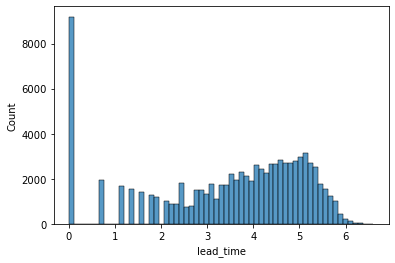

In [303]:
sns.histplot(df_numerical['lead_time'])

In [304]:
print("Number of records before dropping outlier", len(df_numerical))
df = df[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
df_numerical = df_numerical[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)].reset_index(drop=True)
print("Number of records after dropping outlier", len(df_numerical))


Number of records before dropping outlier 87138
Number of records after dropping outlier 71031


# 4. Feature Selection 

In [305]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,booked_by
0,Resort Hotel,0,1.9459,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0000,0,Transient,75.0000,0,0,Individually
1,Resort Hotel,0,2.5649,2015,July,27,1,0,1,1,0.0000,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0000,0,Transient,75.0000,0,0,Agent
2,Resort Hotel,0,2.6391,2015,July,27,1,0,2,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0000,0,Transient,98.0000,0,1,Agent
3,Resort Hotel,0,0.0000,2015,July,27,1,0,2,2,0.0000,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0.0000,0,Transient,107.0000,0,0,Individually
4,Resort Hotel,0,2.1972,2015,July,27,1,0,2,2,0.0000,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0000,0,Transient,103.0000,0,1,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,0,3.0445,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,2,Agent
71027,City Hotel,0,3.1355,2017,August,35,30,2,5,2,0.0000,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,0,Agent
71028,City Hotel,0,4.6250,2017,August,35,31,2,5,3,0.0000,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,0,Transient,225.4300,0,2,Agent
71029,City Hotel,0,4.6913,2017,August,35,31,2,5,2,0.0000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,0,Transient,104.4000,0,0,Agent


In [306]:
# plt.figure(figsize=(30,10))
# sns.heatmap(df_numerical.corr(), annot=True)
# plt.show()

- lead time shows slight correlation with booking cancelation other features dont show significant relation 
- lets plot scatter plots to understand it better

In [307]:
# for i, col in enumerate(graph_columns):
#     plt.figure(i)
#     sns.scatterplot(data=df_numerical,
#                    x=col,
#                    y='is_canceled')
#     plt.title(col + ' Vs is_canceled Scatterplot')  

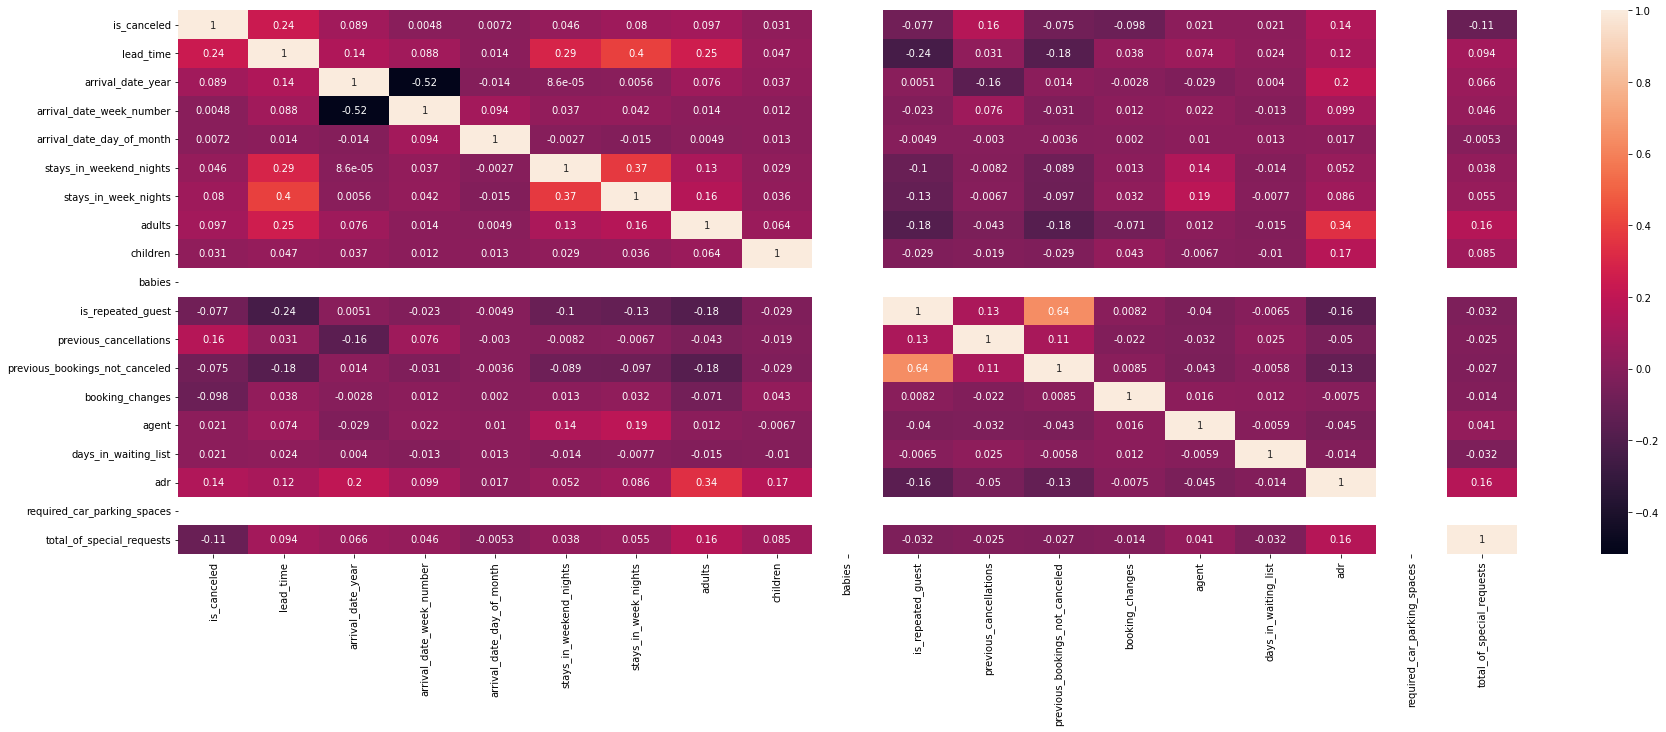

In [308]:
plt.figure(figsize=(30,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [309]:
df['babies'].unique()

array([0], dtype=int64)

In [310]:
df['required_car_parking_spaces'].unique()

array([0], dtype=int64)

- as there is only one unique value for babies and required car parking spaces, we can delete these column

In [311]:

df_numerical.drop(columns=['babies','required_car_parking_spaces'],inplace=True)
df.drop(columns=['babies','required_car_parking_spaces'],inplace=True)

In [312]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,total_of_special_requests,booked_by
0,Resort Hotel,0,1.9459,2015,July,27,1,0,1,1,0.0000,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0000,0,Transient,75.0000,0,Individually
1,Resort Hotel,0,2.5649,2015,July,27,1,0,1,1,0.0000,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0000,0,Transient,75.0000,0,Agent
2,Resort Hotel,0,2.6391,2015,July,27,1,0,2,2,0.0000,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0000,0,Transient,98.0000,1,Agent
3,Resort Hotel,0,0.0000,2015,July,27,1,0,2,2,0.0000,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0.0000,0,Transient,107.0000,0,Individually
4,Resort Hotel,0,2.1972,2015,July,27,1,0,2,2,0.0000,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0000,0,Transient,103.0000,1,Agent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,0,3.0445,2017,August,35,30,2,5,2,0.0000,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,2,Agent
71027,City Hotel,0,3.1355,2017,August,35,30,2,5,2,0.0000,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,Agent
71028,City Hotel,0,4.6250,2017,August,35,31,2,5,3,0.0000,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,0,Transient,225.4300,2,Agent
71029,City Hotel,0,4.6913,2017,August,35,31,2,5,2,0.0000,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,0,Transient,104.4000,0,Agent


In [313]:
# Categorical Variables
df_categorical = df.select_dtypes(include=['object'])
df_categorical

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by
0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Individually
1,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent
2,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent
3,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Individually
4,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,No Deposit,Transient,Agent
...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent
71027,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent
71028,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent
71029,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent


In [314]:
# Now i will add the 2 binary column to this df and one categorical 
df_categorical.insert(loc=0, column='is_canceled',value=df['is_canceled'])
df_categorical['is_repeated_guest'] = df['is_repeated_guest']

In [315]:
df_categorical

,is_canceled,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by,is_repeated_guest
0,0,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Individually,0
1,0,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent,0
2,0,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0
3,0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Individually,0
4,0,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,No Deposit,Transient,Agent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,0,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0
71027,0,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0
71028,0,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent,0
71029,0,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0


In [316]:
target_by_cats(df_categorical)

,mean,count,diff,%diff
hotel,,,,
City Hotel,0.3100,46858,0.0200,6.4516
Resort Hotel,0.2700,24173,-0.0200,-7.4074


,mean,count,diff,%diff
arrival_date_month,,,,
April,0.3300,6449,0.0400,12.1212
August,0.3500,8796,0.0600,17.1429
December,0.2900,4061,-0.0000,-0.0000
February,0.2500,5068,-0.0400,-16.0000
January,0.2400,3735,-0.0500,-20.8333
July,0.3500,7952,0.0600,17.1429
June,0.3200,6284,0.0300,9.3750
March,0.2600,6365,-0.0300,-11.5385
May,0.3100,6924,0.0200,6.4516


,mean,count,diff,%diff
meal,,,,
BB,0.2800,55007,-0.0100,-3.5714
FB,0.3100,232,0.0200,6.4516
HB,0.3000,6570,0.0100,3.3333
SC,0.3600,8947,0.0700,19.4444
Undefined,0.1900,275,-0.1000,-52.6316


,mean,count,diff,%diff
country,,,,
ABW,0.0000,2,-0.2900,-inf
AGO,0.4500,196,0.1600,35.5556
ALB,0.2000,10,-0.0900,-45.0000
AND,1.0000,4,0.7100,71.0000
ARE,0.8600,35,0.5700,66.2791
...,...,...,...,...
VGB,1.0000,1,0.7100,71.0000
VNM,0.2500,8,-0.0400,-16.0000
ZAF,0.3500,65,0.0600,17.1429


,mean,count,diff,%diff
market_segment,,,,
Aviation,0.2000,196,-0.0900,-45.0000
Complementary,0.1600,477,-0.1300,-81.2500
Corporate,0.1400,3007,-0.1500,-107.1429
Direct,0.1700,8488,-0.1200,-70.5882
Groups,0.2800,3919,-0.0100,-3.5714
Offline TA/TO,0.1500,11740,-0.1400,-93.3333
Online TA,0.3700,43202,0.0800,21.6216
Undefined,1.0000,2,0.7100,71.0000


,mean,count,diff,%diff
distribution_channel,,,,
Corporate,0.1400,3660,-0.1500,-107.1429
Direct,0.1700,9344,-0.1200,-70.5882
GDS,0.1800,176,-0.1100,-61.1111
TA/TO,0.3200,57847,0.0300,9.3750
Undefined,1.0000,4,0.7100,71.0000


,mean,count,diff,%diff
reserved_room_type,,,,
A,0.2800,48962,-0.0100,-3.5714
B,0.3000,647,0.0100,3.3333
C,0.3100,226,0.0200,6.4516
D,0.3300,14970,0.0400,12.1212
E,0.3400,4368,0.0500,14.7059
F,0.2400,1035,-0.0500,-20.8333
G,0.2800,532,-0.0100,-3.5714
H,0.5700,281,0.2800,49.1228
L,0.4000,5,0.1100,27.5000


,mean,count,diff,%diff
assigned_room_type,,,,
A,0.3200,40768,0.0300,9.3750
B,0.1900,1379,-0.1000,-52.6316
C,0.1400,1153,-0.1500,-107.1429
D,0.2700,19103,-0.0200,-7.4074
E,0.2800,5351,-0.0100,-3.5714
F,0.1700,1657,-0.1200,-70.5882
G,0.2000,798,-0.0900,-45.0000
H,0.4700,356,0.1800,38.2979
I,0.0200,243,-0.2700,-1350.0000


,mean,count,diff,%diff
deposit_type,,,,
No Deposit,0.2900,70113,-0.0000,-0.0000
Non Refund,0.9500,845,0.6600,69.4737
Refundable,0.2900,73,-0.0000,-0.0000


,mean,count,diff,%diff
customer_type,,,,
Contract,0.1800,2518,-0.1100,-61.1111
Group,0.0800,421,-0.2100,-262.5000
Transient,0.3200,58740,0.0300,9.3750
Transient-Party,0.1600,9352,-0.1300,-81.2500


,mean,count,diff,%diff
booked_by,,,,
Agent,0.3200,62015,0.0300,9.3750
Company,0.1300,3633,-0.1600,-123.0769
Company through Agent,0.1000,125,-0.1900,-190.0000
Individually,0.1600,5258,-0.1300,-81.2500


,mean,count,diff,%diff
is_repeated_guest,,,,
0,0.3000,68939,0.0100,3.3333
1,0.0900,2092,-0.2000,-222.2222


**Observations**
- Hotel: cancellation % doesnd change much with the hotel type
- Month: April, may, june, july, august have more than 30% booking of cancellation 
- Meal: BB, FB, HB constitute to majority of meals and there is very less change in %cancellation in these type of meals
- 172 countries we can bucket this column according to continent or ignore the column. For now i willignore it
- market_segemt: There is significcant difference in % with marcket segment
- distribution_channel: here also % changes with distribution channel
- reserved room type: We might want to bucket it and keep top 4 and classify remainings as 'other'. % is not chaging that much with reserved room type.
- assigned room type: Again we might want to bucket it but % is not changing much
- deposit type: even though almost all the records are for no deposit, non refundable records are being cancelled 95% of the time which is very big number
- customer type: % is changing
- booked_by: % is changing considerably
- is_repeated guest: if gueast is repeated then he/she cancel the booking only for 9% of the times

**Conclusion**
- Categorical variables to consider: 'Marcket_segment','deposit_type','customer_type','booked_by','is_repeated_guest'

**Tasks**
- Create a column is_room_changed which specifies if assigned room is not same as reserved room 
- Reduce the unique values in contry, reserved room type and assigned room type column by keeping the top few recordsand merging the remaining records in 'other' category
- Convert the text month column into month number 

In [317]:
df_categorical['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)
df['is_room_changed'] = np.where((df_categorical['reserved_room_type'] == df_categorical['assigned_room_type']),0,1)   

In [318]:
top_5_countries = df_categorical.groupby('country')['is_canceled'].count().sort_values(ascending=False).head(5)
top_3_reserved_room_types = df_categorical.groupby('reserved_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)
top_3_assigned_room_types = df_categorical.groupby('assigned_room_type')['is_canceled'].count().sort_values(ascending=False).head(3)

In [319]:
df.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

df_categorical.loc[~(df_categorical['country'].isin(top_5_countries.index)),'country'] = 'Other'
df_categorical.loc[~(df_categorical['reserved_room_type'].isin(top_3_reserved_room_types.index)),'reserved_room_type'] = 'Other'
df_categorical.loc[~(df_categorical['assigned_room_type'].isin(top_3_assigned_room_types.index)),'assigned_room_type'] = 'Other'

In [320]:
df['assigned_room_type'].unique()

array(['Other', 'A', 'D', 'E'], dtype=object)

In [321]:
categorical_columns = df_categorical.loc[:, df_categorical.columns != 'is_canceled']

# for i, col in enumerate(categorical_columns):
#     f = plt.figure(figsize=(20,8))
#     plt.figure(i)
#     sns.countplot(data=df_categorical, x = df_categorical[col], hue=df_categorical['is_canceled'])
#     plt.title(col + ' Histogram before Outlier removal') 

In [322]:
categorical_columns

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by,is_repeated_guest,is_room_changed
0,Resort Hotel,July,BB,GBR,Direct,Direct,A,Other,No Deposit,Transient,Individually,0,1
1,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent,0,0
2,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0,0
3,Resort Hotel,July,BB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Individually,0,0
4,Resort Hotel,July,FB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Agent,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,August,BB,Other,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0,0
71027,City Hotel,August,BB,Other,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0,0
71028,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent,0,0
71029,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0,0


In [323]:
# for i, col in enumerate(categorical_columns):
#     f = plt.figure(figsize=(20,8))
#     plt.figure(i)
#     sns.violinplot(data=df, x = col, y='lead_time', hue=df_categorical['is_canceled'], split=True)
#     plt.title(col + ' Histogram before Outlier removal') 

In [324]:
month_map = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
df.arrival_date_month = df.arrival_date_month.map(month_map).astype(int)

In [325]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,total_of_special_requests,booked_by,is_room_changed
0,Resort Hotel,0,1.9459,2015,7,27,1,0,1,1,0.0000,BB,GBR,Direct,Direct,0,0,0,A,Other,0,No Deposit,0.0000,0,Transient,75.0000,0,Individually,1
1,Resort Hotel,0,2.5649,2015,7,27,1,0,1,1,0.0000,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0000,0,Transient,75.0000,0,Agent,0
2,Resort Hotel,0,2.6391,2015,7,27,1,0,2,2,0.0000,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0000,0,Transient,98.0000,1,Agent,0
3,Resort Hotel,0,0.0000,2015,7,27,1,0,2,2,0.0000,BB,PRT,Direct,Direct,0,0,0,Other,Other,0,No Deposit,0.0000,0,Transient,107.0000,0,Individually,0
4,Resort Hotel,0,2.1972,2015,7,27,1,0,2,2,0.0000,FB,PRT,Direct,Direct,0,0,0,Other,Other,0,No Deposit,303.0000,0,Transient,103.0000,1,Agent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,0,3.0445,2017,8,35,30,2,5,2,0.0000,BB,Other,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,2,Agent,0
71027,City Hotel,0,3.1355,2017,8,35,30,2,5,2,0.0000,BB,Other,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0000,0,Transient,96.1400,0,Agent,0
71028,City Hotel,0,4.6250,2017,8,35,31,2,5,3,0.0000,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0000,0,Transient,225.4300,2,Agent,0
71029,City Hotel,0,4.6913,2017,8,35,31,2,5,2,0.0000,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0000,0,Transient,104.4000,0,Agent,0


In [326]:
categorical_columns

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,booked_by,is_repeated_guest,is_room_changed
0,Resort Hotel,July,BB,GBR,Direct,Direct,A,Other,No Deposit,Transient,Individually,0,1
1,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Agent,0,0
2,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0,0
3,Resort Hotel,July,BB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Individually,0,0
4,Resort Hotel,July,FB,PRT,Direct,Direct,Other,Other,No Deposit,Transient,Agent,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,City Hotel,August,BB,Other,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0,0
71027,City Hotel,August,BB,Other,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Agent,0,0
71028,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Agent,0,0
71029,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Agent,0,0


In [327]:
df_small = df[['is_canceled','lead_time','previous_cancellations','adr','total_of_special_requests','market_segment','deposit_type','customer_type','booked_by','is_room_changed','country','agent','booking_changes','arrival_date_week_number','arrival_date_year']]

- For modeling, I will be using all the features present as well as only the features that I have selected and then I will try to compair performace in both of them. The features I have selected are stored in the param.

In [328]:
param = ['lead_time', 'previous_cancellations', 'adr',
       'total_of_special_requests', 'is_room_changed', 'agent',
       'booking_changes', 'arrival_date_week_number', 'arrival_date_year',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'booked_by_Agent', 'booked_by_Company',
       'booked_by_Company through Agent', 'booked_by_Individually',
       'country_DEU', 'country_ESP', 'country_FRA', 'country_GBR',
       'country_Other', 'country_PRT']

# 5. Encoding categorical variables, Data splitting, Normlizing

In [329]:
#Convering categorical to binary
df = pd.get_dummies(df, prefix_sep='_', drop_first=False)

#train test split
train_var = df.drop(['is_canceled'], axis=1)
test_var = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(train_var, test_var, test_size=0.20, random_state=1)

In [330]:
#Data scaling
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

std_scaler_2 = StandardScaler()
std_scaler_2.fit(X_train[param])
X_train_std_small = std_scaler_2.transform(X_train[param])
X_test_std_small = std_scaler_2.transform(X_test[param])

In [331]:
X_train[param]

,lead_time,previous_cancellations,adr,total_of_special_requests,is_room_changed,agent,booking_changes,arrival_date_week_number,arrival_date_year,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,booked_by_Agent,booked_by_Company,booked_by_Company through Agent,booked_by_Individually,country_DEU,country_ESP,country_FRA,country_GBR,country_Other,country_PRT
43066,3.0910,0,116.9500,3,0,14.0000,0,45,2015,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
20960,4.4998,0,52.8000,2,0,240.0000,0,13,2017,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
37341,5.1475,0,100.0000,0,0,286.0000,0,18,2017,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
21155,2.0794,0,68.0000,1,0,241.0000,0,14,2017,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3434,4.5850,0,73.0000,0,0,240.0000,0,22,2016,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,3.4340,0,95.0000,1,0,0.0000,1,21,2016,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
20609,2.0794,0,65.0000,0,0,240.0000,0,10,2017,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
21440,4.9416,0,74.0000,1,0,251.0000,0,17,2017,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
50057,4.7095,0,80.2400,0,0,83.0000,0,24,2016,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


In [332]:
df_results = pd.DataFrame()

# 6 Modeling

## 6.1 Logistic Regression 

### 6.1.1 Using all Features

In [333]:
logreg = LogisticRegression(max_iter=500).fit(X_train_std, y_train)
scores = cross_val_score(logreg, X_train_std, y_train, cv=5)
logreg_pred = logreg.predict(X_test_std)
features_used = len(logreg.coef_[0][(logreg.coef_[0] > 0.01) | (logreg.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(logreg.score(X_test_std, y_test)))
logreg_dict = {"Model": "Logistic Regression",
              "Accuracy": round(logreg.score(X_test_std, y_test),3),
              "Recall": round(recall_score(y_test, logreg_pred),3),
              "Precision": round(precision_score(y_test, logreg_pred),3),
              "False Negative": confusion_matrix(y_test, logreg_pred)[1][0],
              "False Positive": confusion_matrix(y_test, logreg_pred)[0][1],
              "Features Used": features_used}
df_results = df_results.append(logreg_dict,ignore_index=True)

Average cross validation score: 0.788
Test accuracy: 0.783


C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\2489698529.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(logreg_dict,ignore_index=True)


### 6.1.2 Using selected features

In [334]:
#Logistic regression using selected the features

logreg = LogisticRegression(max_iter=500).fit(X_train_std_small, y_train)
scores = cross_val_score(logreg, X_train_std_small, y_train, cv=5)
logreg_pred = logreg.predict(X_test_std_small)
features_used = len(logreg.coef_[0][(logreg.coef_[0] > 0.01) | (logreg.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(logreg.score(X_test_std_small, y_test)))
logreg_dict = {"Model": "Logistic Regression for selected features",
              "Accuracy": round(logreg.score(X_test_std_small, y_test),3),
              "Recall": round(recall_score(y_test, logreg_pred),3),
              "Precision": round(precision_score(y_test, logreg_pred),3),
              "False Negative": confusion_matrix(y_test, logreg_pred)[1][0],
              "False Positive": confusion_matrix(y_test, logreg_pred)[0][1],
              "Features Used": features_used}
df_results = df_results.append(logreg_dict,ignore_index=True)

Average cross validation score: 0.786
Test accuracy: 0.782


C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3779315840.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(logreg_dict,ignore_index=True)


In [335]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33


**Observations**

- For the logistic regression using all the features we are getting accuracy of 0.78 and recall (which is the costlier parameter in this case) of 0.50 using 52 features 
- Where as if we use only selected features then we are getting same accuracy and recall but with only 32 features. 
- Number of features are calculated based on the significance of coefficients. If coefficient is > 0.01 or < -0.01 then it is considered important 

## 6.2 Lasso Regularization 

### 6.2.1 Using all features

- I am implementing lasso classifier using logisticRegression with penalty as l1
- c parameter is the inverse of lambda value ie. c = 1/lambda
- I checked performance parameters for c = [0.001, 0.01, 0.1, 1 , 1] and found out model working great for lower values of c thus I have decided to use [0.0001,0.001,0.01] 

In [336]:
for a in [0.0001,0.001,0.01]:
    lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=a,solver="saga").fit(X_train_std, y_train)
    scores = cross_val_score(lasso_classification, X_train_std, y_train, cv=10)
    lasso_pred = lasso_classification.predict(X_test_std)

- After looking at the accuracy and recall it is clear that model with alpha = 0.01 is performing the best out of 3 as recall is very less for the other two
- This model contains more features but it give good recall so I am adding this in df_result 

In [337]:
lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=0.01,solver="saga").fit(X_train_std, y_train)
scores = cross_val_score(lasso_classification, X_train_std, y_train, cv=10)
lasso_pred = lasso_classification.predict(X_test_std)
features_used = len(lasso_classification.coef_[0][(lasso_classification.coef_[0] > 0.01) 
                                                  | (lasso_classification.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
lasso_dict = {"Model": "Lasso for alpha = 100",
          "Accuracy": round(lasso_classification.score(X_test_std, y_test),3),
          "Recall": round(recall_score(y_test, lasso_pred),3),
          "Precision": round(precision_score(y_test, lasso_pred),3),
          "False Negative": confusion_matrix(y_test, lasso_pred)[1][0],
          "False Positive": confusion_matrix(y_test, lasso_pred)[0][1],
          "Features Used": features_used}
df_results = df_results.append(lasso_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\2980602392.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(lasso_dict,ignore_index=True)


### 6.2.2 Using selected features

- In this case I am using only selected features to see the performance parameters if we drop unwanted features 

In [338]:
for a in [0.0001,0.001,0.01]:
    lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=a,solver="saga").fit(X_train_std_small, y_train)
    scores = cross_val_score(lasso_classification, X_train_std_small, y_train, cv=10)
    lasso_pred = lasso_classification.predict(X_test_std_small)

- The model with alpha = 0.01 is best performing model so i will add thar model performance in the df_result 

In [339]:
lasso_classification = LogisticRegression(max_iter=1000, penalty='l1',C=0.01,solver="saga").fit(X_train_std_small, y_train)
scores = cross_val_score(lasso_classification, X_train_std_small, y_train, cv=10)
lasso_pred = lasso_classification.predict(X_test_std_small)
features_used = len(lasso_classification.coef_[0][(lasso_classification.coef_[0] > 0.01) 
                                                  | (lasso_classification.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
lasso_dict = {"Model": "Lasso for alpha = 100"+ " for selected features",
          "Accuracy": round(lasso_classification.score(X_test_std_small, y_test),3),
          "Recall": round(recall_score(y_test, lasso_pred),3),
          "Precision": round(precision_score(y_test, lasso_pred),3),
          "False Negative": confusion_matrix(y_test, lasso_pred)[1][0],
          "False Positive": confusion_matrix(y_test, lasso_pred)[0][1],
          "Features Used": features_used}
df_results = df_results.append(lasso_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3223280326.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(lasso_dict,ignore_index=True)


In [340]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22


**Observations**

- Performace parameters as well as features used are same in both the cases
- Time taken in the 2nd case is considerably low

## 6.3 Ridge Regularization

### 6.3.1 Using all the features

In [341]:
for a in [0.01,0.1,1,10,100]:
    ridgeClassifier = RidgeClassifier(alpha=a)
    ridgeClassifier.fit(X_train_std, y_train)
    ridge_pred = ridgeClassifier.predict(X_test_std)    

- All the ridge models are giving same results for all the performance parameters
- Model with alpha = 100 is using lesser number of variables so ill use this as the best ridge regularization model

In [342]:
ridgeClassifier = RidgeClassifier(alpha=100)
ridgeClassifier.fit(X_train_std, y_train)
cv_scores = cross_val_score(ridgeClassifier,X_train_std, y_train, cv=10)
ridge_pred = ridgeClassifier.predict(X_test_std)
features_used = len(ridgeClassifier.coef_[0][(ridgeClassifier.coef_[0] > 0.01) 
                                             | (ridgeClassifier.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
ridge_dict = {"Model": "Ridge for alpha = 100",
          "Accuracy": round(ridgeClassifier.score(X_test_std, y_test),3),
          "Recall": round(recall_score(y_test, ridge_pred),3),
          "Precision": round(precision_score(y_test, ridge_pred),3),
          "False Negative": confusion_matrix(y_test, ridge_pred)[1][0],
          "False Positive": confusion_matrix(y_test, ridge_pred)[0][1],
          "Features Used": features_used}
df_results = df_results.append(ridge_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3800154950.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(ridge_dict,ignore_index=True)


### 6.3.2 Using selected features

In [343]:
for a in [0.01,0.1,1,10,100]:
    ridgeClassifier = RidgeClassifier(alpha=a)
    ridgeClassifier.fit(X_train_std_small, y_train)
    ridge_pred = ridgeClassifier.predict(X_test_std_small)    

- All the models are performing exactly same
- I am choosing alpha as 100 as I have used same alpha for last model which uses all the features

In [344]:
ridgeClassifier = RidgeClassifier(alpha=100)
ridgeClassifier.fit(X_train_std_small, y_train)
cv_scores = cross_val_score(ridgeClassifier,X_train_std_small, y_train, cv=10)
ridge_pred = ridgeClassifier.predict(X_test_std_small)
features_used = len(ridgeClassifier.coef_[0][(ridgeClassifier.coef_[0] > 0.01) 
                                             | (ridgeClassifier.coef_[0] < -0.01)]) - 1
features_used = np.where(features_used == -1, 0, features_used)
ridge_dict = {"Model": "Ridge for alpha = 100 for selected features",
          "Accuracy": round(ridgeClassifier.score(X_test_std_small, y_test),3),
          "Recall": round(recall_score(y_test, ridge_pred),3),
          "Precision": round(precision_score(y_test, ridge_pred),3),
          "False Negative": confusion_matrix(y_test, ridge_pred)[1][0],
          "False Positive": confusion_matrix(y_test, ridge_pred)[0][1],
          "Features Used": features_used}
df_results = df_results.append(ridge_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3437726977.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(ridge_dict,ignore_index=True)


In [345]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25


**Observations**

- Performace as well as features used are same in both the cases
- Both the models ran pretty quickly compared to Lasso Regularization models
- Lasso and Ridge use very less featured compared to logesticRegression but result in similar accuracy.
- Logestic give better recall which is the performace parameter under consideration 

## 6.4 Decision Tree

In [346]:
impurity_list = [0.001,0.01,0.0001]
for impurity in impurity_list:
    decision_tree = DecisionTreeClassifier(max_depth=30,
                                       min_samples_split=20,
                                       min_impurity_decrease=impurity,
                                       random_state=0)
    decision_tree.fit(X_train, y_train)
    decision_tree_pred = decision_tree.predict(X_test_std)   

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


- After running the decision tree a few times I have found that max depth sould be greater than 20, min sample size can go below 20 and minimum imourity decrease should be as low as possible thus, I am going for grid search using the above as my hyperparameters 
- We will be using accuracy, recall and precision as scoring parameters
- I am using accuracy to find the best hyper parameter as using recall is giving poor accuracy 
- Cross validation: 5

In [347]:
param_grid = {
    'max_depth': [20,30],
    'min_samples_split': [5,10,20],
    'min_impurity_decrease': [0, 0.0001]
}

In [348]:
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                          param_grid, 
                          cv=5,
                          n_jobs=-1,  #used to marshall all available CPUs
                          scoring=['accuracy','recall','precision'],
                          refit='accuracy'
                         )
gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20, 30],
                         'min_impurity_decrease': [0, 0.0001],
                         'min_samples_split': [5, 10, 20]},
             refit='accuracy', scoring=['accuracy', 'recall', 'precision'])

In [349]:
df_decision_tree_result = decision_tree_grid_search()

In [350]:
df_decision_tree_result

,Accuracy,Recall,Precision,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Model
0,0.7949,0.6394,0.6553,20,0.0000,5,Decision Tree
1,0.7978,0.6354,0.6634,20,0.0000,10,Decision Tree
2,0.8026,0.6363,0.6746,20,0.0000,20,Decision Tree
3,0.8233,0.6361,0.7292,20,0.0001,5,Decision Tree
4,0.8233,0.6363,0.7291,20,0.0001,10,Decision Tree
5,0.8232,0.6358,0.7290,20,0.0001,20,Decision Tree
6,0.7825,0.6125,0.6354,30,0.0000,5,Decision Tree
7,0.7869,0.6107,0.6459,30,0.0000,10,Decision Tree
8,0.7955,0.6226,0.6624,30,0.0000,20,Decision Tree
9,0.8233,0.6361,0.7292,30,0.0001,5,Decision Tree


**Observation**

- For decision tree on average the accuracy is 80% where as recall is 64% which is better than logistic as well as Regularized models
- Model is performing good for Minimum Impurity Decrease of 0.0001
- Lets see best performing decision tree and its important features and add the best performing tree in the df_resuls

In [351]:
best_model_results = pd.DataFrame(gridSearch.cv_results_).loc[gridSearch.best_index_]

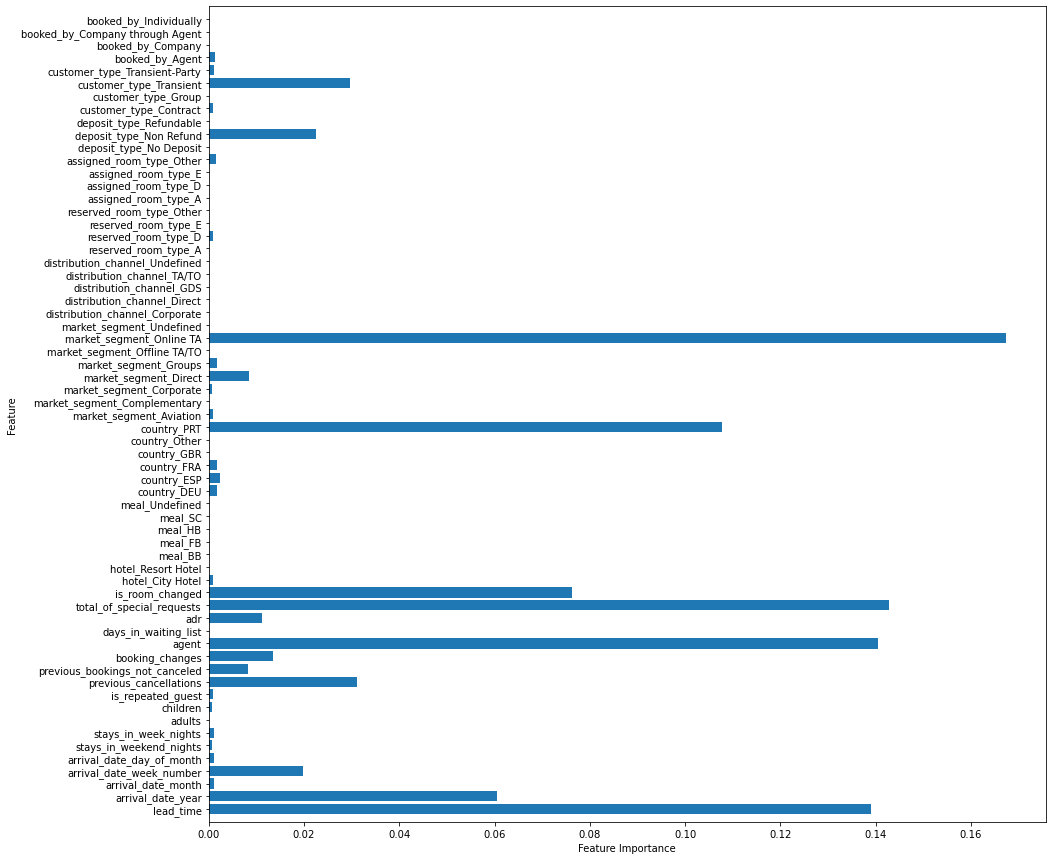

In [352]:
plot_feature_importances(X_train,gridSearch.best_estimator_)

In [353]:
bestClassTree = gridSearch.best_estimator_
decision_tree_pred = bestClassTree.predict(X_test)
features_used = (gridSearch.best_estimator_.feature_importances_>0).sum()
decision_tree_dict = {"Model": "Decision Tree",
              "Accuracy": round(accuracy_score(y_test, decision_tree_pred),3),
              "Recall": round(recall_score(y_test, decision_tree_pred),3),
              "Precision": round(precision_score(y_test, decision_tree_pred),3),
              "False Negative": confusion_matrix(y_test, decision_tree_pred)[1][0],
              "False Positive": confusion_matrix(y_test, decision_tree_pred)[0][1],
              "Features Used": features_used,
              "Max Depth": best_model_results['param_max_depth'],
              "Minimum Impurity Decrease": best_model_results['param_min_impurity_decrease'],
              "Minimum Samples Split": best_model_results['param_min_samples_split']}

df_results = df_results.append(decision_tree_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1336464936.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(decision_tree_dict,ignore_index=True)


In [354]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000


- I did the prooning using max depth, minimum impurity decrease and minimum samples split, now I want to use the cost complexity prooning

In [355]:
path = bestClassTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
len(ccp_alphas)

124

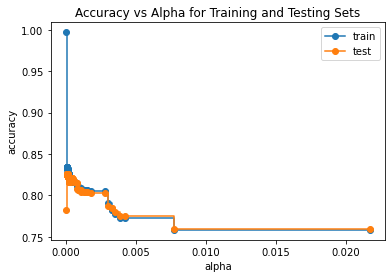

In [356]:
dts = []

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt.fit(X_train,y_train)
    dts.append(dt)
    
train_scores = [dt.score(X_train,y_train) for dt in dts]
test_scores = [dt.score(X_test,y_test) for dt in dts]

fix, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle='steps-post')
ax.legend()
plt.show()


- After looking at all the 126 it looks like best ccp alpha is in initial 2-3 values so lets plot for first few values only

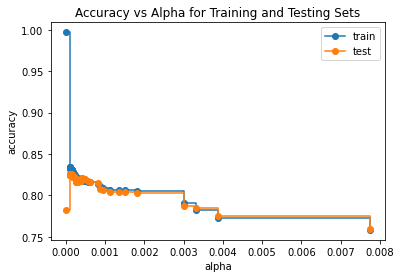

In [357]:
fix, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")
ax.plot(ccp_alphas[0::2], train_scores[0::2], marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[0::2], test_scores[0::2], marker='o', label="test",drawstyle='steps-post')
ax.legend()
plt.show()

- It looks like the accuracy for traina dn test is high for very small alpha values. After looking at the ccp_alphas, I am taking 0.00010218 as my alpha

In [358]:
ccp_alphas

array([0.        , 0.00010003, 0.00010072, 0.00010178, 0.00010299,
       0.00010368, 0.00010417, 0.00010492, 0.00010541, 0.00010578,
       0.00010613, 0.00010792, 0.00010802, 0.00010894, 0.00010914,
       0.00011222, 0.00011249, 0.00011397, 0.00011455, 0.00011516,
       0.00011686, 0.00012149, 0.00012158, 0.00012357, 0.00012434,
       0.00012507, 0.00012591, 0.00012782, 0.00012808, 0.00013419,
       0.00013486, 0.00013761, 0.00013792, 0.00014285, 0.0001441 ,
       0.00014588, 0.0001465 , 0.0001477 , 0.00015084, 0.0001565 ,
       0.00015739, 0.00015958, 0.00016089, 0.00016113, 0.00016191,
       0.00016235, 0.0001649 , 0.00016527, 0.00016682, 0.00016715,
       0.00016843, 0.00017405, 0.00017519, 0.00017643, 0.0001772 ,
       0.00017795, 0.00018364, 0.00018458, 0.000188  , 0.00018885,
       0.00019031, 0.00019653, 0.00019871, 0.00020364, 0.0002077 ,
       0.00020919, 0.00021503, 0.00021985, 0.00022317, 0.00022679,
       0.00022779, 0.00023414, 0.00023948, 0.00023963, 0.00024

In [359]:
decision_tree_ccp = DecisionTreeClassifier(random_state=1, ccp_alpha=0.00010218)
decision_tree_ccp.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00010218, random_state=1)

In [360]:
decision_tree_ccp_pred = decision_tree_ccp.predict(X_test)
accuracy_score(y_test, decision_tree_ccp_pred)
               

0.8243119588935032

In [361]:
features_used = (decision_tree_ccp.feature_importances_>0).sum()
decision_tree_ccp_dict = {"Model": "Decision Tree Cost Complexity prooning",
              "Accuracy": round(accuracy_score(y_test, decision_tree_ccp_pred),3),
              "Recall": round(recall_score(y_test, decision_tree_ccp_pred),3),
              "Precision": round(precision_score(y_test, decision_tree_ccp_pred),3),
              "False Negative": confusion_matrix(y_test, decision_tree_ccp_pred)[1][0],
              "False Positive": confusion_matrix(y_test, decision_tree_ccp_pred)[0][1],
              "Features Used": features_used,
              "Cost Complexity": 0.00010218}

df_results = df_results.append(decision_tree_ccp_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\2719515508.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(decision_tree_ccp_dict,ignore_index=True)


In [362]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Cost Complexity
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000,NaN
7,Decision Tree Cost Complexity prooning,0.8240,0.6390,0.7300,1507,989,33,NaN,NaN,NaN,0.0001


## 6.5 Random Forest

In [363]:
# random_forest = RandomForestClassifier(random_state=1)
# param_grid = { 
#     'max_depth': [10,15,20],
#     'min_samples_split': [5,10,20],
#     'min_impurity_decrease': [0, 0.0001],
#     'criterion' :['gini', 'entropy'],
#     'ccp_alpha' : [0.00010218, 0.00010432, 0.00010515]
# }
# random_forest_grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5)
# random_forest_grid_search.fit(X_train, y_train)

# best_random_forest = random_forest_grid_search.best_estimator_
# random_forest_pred = best_random_forest.predict(X_test)
# features_used = (best_random_forest.feature_importances_>0).sum()
# random_forest_dict = {"Model": "Random Forest",
#               "Accuracy": round(accuracy_score(y_test, random_forest_pred),3),
#               "Recall": round(recall_score(y_test, random_forest_pred),3),
#               "Precision": round(precision_score(y_test, random_forest_pred),3),
#               "False Negative": confusion_matrix(y_test, random_forest_pred)[1][0],
#               "False Positive": confusion_matrix(y_test, random_forest_pred)[0][1],
#               "Features Used": features_used,
#               "Max Depth": best_random_forest.get_params().get('max_depth'),
#               "Minimum Impurity Decrease": best_random_forest.get_params().get('min_impurity_decrease'),
#               "Minimum Samples Split": best_random_forest.get_params().get('min_samples_split'),
#               "Cost Complexity" : best_random_forest.get_params().get('ccp_alpha')}


# df_results = df_results.append(random_forest_dict,ignore_index=True)

In [364]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Cost Complexity
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000,NaN
7,Decision Tree Cost Complexity prooning,0.8240,0.6390,0.7300,1507,989,33,NaN,NaN,NaN,0.0001


### 6.5.1 Using all features

- I am using similar hyper parameters that i used in decision tree
- I am also using criterion to calculate the impurity which can be gini or entropy
- Similar to decision tree I am using accuracy, recall and precision as scoring parameters and best estimator is selected based on accuracy

In [365]:
random_forest_2 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': [15,20],
    'min_samples_split': [20],
    'min_impurity_decrease': [0, 0.0001],
    'criterion' :['gini', 'entropy'],
    'ccp_alpha' : [ 0.00010432, 0.00010515]
}
random_forest_grid_search_2 = GridSearchCV(estimator=random_forest_2, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision'],
                          refit='accuracy')
random_forest_grid_search_2.fit(X_train, y_train)

best_random_forest_2 = random_forest_grid_search_2.best_estimator_
random_forest_pred_2 = best_random_forest_2.predict(X_test)
features_used = (best_random_forest_2.feature_importances_>0).sum()
random_forest_dict_2 = {"Model": "Random Forest",
              "Accuracy": round(accuracy_score(y_test, random_forest_pred_2),3),
              "Recall": round(recall_score(y_test, random_forest_pred_2),3),
              "Precision": round(precision_score(y_test, random_forest_pred_2),3),
              "False Negative": confusion_matrix(y_test, random_forest_pred_2)[1][0],
              "False Positive": confusion_matrix(y_test, random_forest_pred_2)[0][1],
              "Features Used": features_used,
              "Max Depth": best_random_forest.get_params().get('max_depth'),
              "Minimum Impurity Decrease": best_random_forest.get_params().get('min_impurity_decrease'),
              "Minimum Samples Split": best_random_forest.get_params().get('min_samples_split'),
              "Cost Complexity" : best_random_forest.get_params().get('ccp_alpha')}


df_results = df_results.append(random_forest_dict_2,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\532359215.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(random_forest_dict_2,ignore_index=True)


In [366]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Cost Complexity
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000,NaN
7,Decision Tree Cost Complexity prooning,0.8240,0.6390,0.7300,1507,989,33,NaN,NaN,NaN,0.0001
8,Random Forest using the features,0.8290,0.5830,0.7790,1743,693,63,20.0000,0.0000,10.0000,0.0001


### 6.5.2 Using selected features

In [367]:
random_forest_3 = RandomForestClassifier(random_state=1)
param_grid = { 
    'max_depth': [15,20],
    'min_samples_split': [20],
    'min_impurity_decrease': [0, 0.0001],
    'criterion' :['gini', 'entropy'],
    'ccp_alpha' : [ 0.00010432, 0.00010515]
}
random_forest_grid_search_3 = GridSearchCV(estimator=random_forest_3, param_grid=param_grid, cv= 5,scoring=['accuracy','recall','precision'],
                          refit='accuracy')
random_forest_grid_search_3.fit(X_train[param], y_train)

best_random_forest_3 = random_forest_grid_search_3.best_estimator_
random_forest_pred_3 = best_random_forest_3.predict(X_test[param])
features_used = (best_random_forest_3.feature_importances_>0).sum()
random_forest_dict_3 = {"Model": "Random Forest using selected features",
              "Accuracy": round(accuracy_score(y_test, random_forest_pred_2),3),
              "Recall": round(recall_score(y_test, random_forest_pred_2),3),
              "Precision": round(precision_score(y_test, random_forest_pred_2),3),
              "False Negative": confusion_matrix(y_test, random_forest_pred_2)[1][0],
              "False Positive": confusion_matrix(y_test, random_forest_pred_2)[0][1],
              "Features Used": features_used,
              "Max Depth": best_random_forest.get_params().get('max_depth'),
              "Minimum Impurity Decrease": best_random_forest.get_params().get('min_impurity_decrease'),
              "Minimum Samples Split": best_random_forest.get_params().get('min_samples_split'),
              "Cost Complexity" : best_random_forest.get_params().get('ccp_alpha')}


df_results = df_results.append(random_forest_dict_3,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3401745520.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(random_forest_dict_3,ignore_index=True)


**Observations**

- All the performance parameters are exactly same for both the random forest models 
- Features used in 2nd model are almost half of the first model
- Comaring the random forest with other models, accuracy of the random forest is good bur recall is less than decision tree
- Time taken for random forest is very high compared to other models maybe except lasso regularization model

In [368]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Cost Complexity
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000,NaN
7,Decision Tree Cost Complexity prooning,0.8240,0.6390,0.7300,1507,989,33,NaN,NaN,NaN,0.0001
8,Random Forest using the features,0.8290,0.5830,0.7790,1743,693,63,20.0000,0.0000,10.0000,0.0001
9,Random Forest,0.8290,0.5830,0.7790,1743,693,34,20.0000,0.0000,10.0000,0.0001


## 6.6 XGBoost

### 6.6.1 Using all the features

- Using XGBClassifier with objective as binary logistic model
- Using max_depth, alpha and lambda values used in decision tree, Ridge and Lasso Regularization 
- learning is how fast your model learns. If the learning rate is high then weight for first models is more than lst models where as if learning rate is low then weights are similar
- I am using range of learning rates to find the best one

In [369]:
for rate in [0.1,0.5,0.75,0.9]:
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=30,learning_rate=rate,reg_alpha=100,reg_lambda=100)
    xgb_model.fit(X_train, y_train)

    xgb_pred = xgb_model.predict(X_test)

- After looking at all the models with different leaning rate, it is evident that accuracy and recall is better for rate = 0.75
- So I will add that model results in df_results

In [370]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=30,learning_rate=0.75,reg_alpha=100,reg_lambda=100)
xgb_model.fit(X_train, y_train)
features_used = (xgb_model.feature_importances_>0).sum()
xgb_pred = xgb_model.predict(X_test)
xgb_dict = {"Model": "XGBoost",
          "Accuracy": round(accuracy_score(y_test, xgb_pred),3),
          "Recall": round(recall_score(y_test, xgb_pred),3),
          "Precision": round(precision_score(y_test, xgb_pred),3),
          "False Negative": confusion_matrix(y_test, xgb_pred)[1][0],
          "False Positive": confusion_matrix(y_test, xgb_pred)[0][1],
          "Features Used": features_used,
          "Learning rate": 0.75}

df_results = df_results.append(xgb_dict,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\2684347813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(xgb_dict,ignore_index=True)


### 6.6.2 Using selected features

In [371]:
for rate in [0.1,0.5,0.75,0.9]:
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=20,learning_rate=rate,reg_alpha=100,reg_lambda=100)
    xgb_model.fit(X_train[param], y_train)

    y_pred = xgb_model.predict(X_test[param])

- Similar to the last model, in this model also learning rate of 0.75 is performing the best
- I will add the performance of that model in df_results

In [372]:
xgb_model_2 = xgb.XGBClassifier(objective="binary:logistic", random_state=1,max_depth=20,learning_rate=rate,reg_alpha=100,reg_lambda=100)
xgb_model_2.fit(X_train[param], y_train)
xgb_pred_2 = xgb_model_2.predict(X_test[param])
features_used = (xgb_model_2.feature_importances_>0).sum()
xgb_dict_2 = {"Model": "XGBoost with selected features",
          "Accuracy": round(accuracy_score(y_test, xgb_pred),3),
          "Recall": round(recall_score(y_test, xgb_pred),3),
          "Precision": round(precision_score(y_test, xgb_pred),3),
          "False Negative": confusion_matrix(y_test, xgb_pred)[1][0],
          "False Positive": confusion_matrix(y_test, xgb_pred)[0][1],
          "Features Used": features_used,
          "Learning rate": 0.75}

df_results = df_results.append(xgb_dict_2,ignore_index=True)

C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\289764577.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(xgb_dict_2,ignore_index=True)


## 6.7 Artifical Neral Network

### 6.7.1 Using all features

- In the frst model I am using only 2 hidden layers as i want to keep it simple and small
- Activation function used is relu as is the most common activation function. I will try other functions later

In [373]:
nural_net = MLPClassifier(hidden_layer_sizes=[35, 20], alpha=0.001, solver='adam', activation='relu',random_state=1)
nural_net.fit(X_train_std, y_train)
nural_net_pred = nural_net.predict(X_test_std)

print("Accuracy for model 1: ",round(accuracy_score(y_test, nural_net_pred),3))
print("Recall for model 1: ",round(recall_score(y_test, nural_net_pred),3))
print("Precision for model 1: ",round(precision_score(y_test, nural_net_pred),3))

Accuracy for model 1:  0.82
Recall for model 1:  0.61
Precision for model 1:  0.732


- For the second model, I am increasing the size to get higher accuracy 

In [374]:
nural_net_2 = MLPClassifier(hidden_layer_sizes=[35, 20, 20, 20], alpha=0.001, solver='adam', activation='relu',random_state=1)
nural_net_2.fit(X_train_std, y_train)
nural_net_pred_2 = nural_net_2.predict(X_test_std)

print("Accuracy for model 2: ",round(accuracy_score(y_test, nural_net_pred_2),3))
print("Recall for model 2: ",round(recall_score(y_test, nural_net_pred_2),3))
print("Precision for model 2: ",round(precision_score(y_test, nural_net_pred_2),3))

Accuracy for model 2:  0.812
Recall for model 2:  0.634
Precision for model 2:  0.699


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


- Now that I have ran couple of models, I want to try using different hyperparameters
- Along with relu ill use tanh
- Hidden layers will vary between 20 and 35
- These hyperparameters should create 32 models 

In [375]:
df_neural_nets_results = pd.DataFrame()

In [376]:
i = 0
for activation in ['relu','tanh']:
    for alpha in [0.001,0.005]:
        for hl1 in [35,25]:
            for hl2 in [35,25]:
                for hl3 in [30,20]:
                    nural_net_nested = MLPClassifier(max_iter=100, hidden_layer_sizes=[hl1,hl2,hl3,25], alpha=alpha, solver='adam', activation=activation,random_state=1)
                    nural_net_nested.fit(X_train_std, y_train)
                    nural_net_nested_pred = nural_net_nested.predict(X_test_std)
                    neural_nets_dict_2 = {"Model": "Neural Nets",
                                          "Accuracy": round(accuracy_score(y_test, nural_net_nested_pred),3),
                                          "Recall": round(recall_score(y_test, nural_net_nested_pred),3),
                                          "Precision": round(precision_score(y_test, nural_net_nested_pred),3),
                                          "False Negative": confusion_matrix(y_test, nural_net_nested_pred)[1][0],
                                          "False Positive": confusion_matrix(y_test, nural_net_nested_pred)[0][1],
                                          "Hidden Layers": str(hl1) + ',' + str(hl2) + ',' + str(hl3) + ',' + '25',
                                          "Activation Function": activation,
                                          "Alpha": alpha}
                    df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)
                    print('For ' + str(i) + ' accuracy: '+ str(accuracy_score(y_test, nural_net_nested_pred)))
                    print('For ' + str(i) + ' recall: '+ str(recall_score(y_test, nural_net_nested_pred)))
                    i = i+1
                    


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 0 accuracy: 0.8168508481734357
For 0 recall: 0.631969370662838


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 1 accuracy: 0.8114309847258394
For 1 recall: 0.6590093323761665


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 2 accuracy: 0.8134722319983106
For 2 recall: 0.6740847092605886


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 3 accuracy: 0.8157950306187091
For 3 recall: 0.6125867432400096


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 4 accuracy: 0.8124164144435841
For 4 recall: 0.6377123713807131


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 5 accuracy: 0.8149503765749279
For 5 recall: 0.6441732471883226


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 6 accuracy: 0.8169916238473992
For 6 recall: 0.6460875807609476


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 7 accuracy: 0.8163581333145632
For 7 recall: 0.6212012443168222


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 8 accuracy: 0.8155838671077638
For 8 recall: 0.6482412060301508


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 9 accuracy: 0.8158654184556908
For 9 recall: 0.6913137114142139


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 10 accuracy: 0.8157246427817273
For 10 recall: 0.6508734146925101


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 11 accuracy: 0.8159358062926726
For 11 recall: 0.6197654941373534


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 12 accuracy: 0.81185331174773
For 12 recall: 0.6489590811198851


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 13 accuracy: 0.814316886042092
For 13 recall: 0.6539842067480258


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 14 accuracy: 0.8126979657915112
For 14 recall: 0.63555874611151


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 15 accuracy: 0.8138945590202014
For 15 recall: 0.6106724096673846


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 16 accuracy: 0.8150207644119096
For 16 recall: 0.6518305814788227


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 17 accuracy: 0.8150207644119096
For 17 recall: 0.6300550370902129


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 18 accuracy: 0.8165692968255086
For 18 recall: 0.6477626226369945


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 19 accuracy: 0.8162877454775814
For 19 recall: 0.631969370662838


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 20 accuracy: 0.8159358062926726
For 20 recall: 0.626465661641541


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 21 accuracy: 0.8174139508692898
For 21 recall: 0.6642737497008854


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 22 accuracy: 0.817062011684381
For 22 recall: 0.6384302464704474


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 23 accuracy: 0.8211445062293236
For 23 recall: 0.6293371620004786


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 24 accuracy: 0.8131906806503836
For 24 recall: 0.6403445800430725


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 25 accuracy: 0.814316886042092
For 25 recall: 0.6257477865518066


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 26 accuracy: 0.8158654184556908
For 26 recall: 0.6532663316582915


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 27 accuracy: 0.8171323995213627
For 27 recall: 0.6312514955731036


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 28 accuracy: 0.8166396846624904
For 28 recall: 0.624551328068916


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 29 accuracy: 0.8176955022172169
For 29 recall: 0.6535056233548696


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


For 30 accuracy: 0.8187513197719434
For 30 recall: 0.63555874611151
For 31 accuracy: 0.8216372210881959
For 31 recall: 0.6374730796841349


C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\1622723806.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)


- Out of the 32 models lets see the best model
- Model with hidden layers 25,35,30,25, activation function as tanh and alpha as 0.001 is giving accuracy of 0.819 which is similar to most of the other models but the recall for this model is 0.6920 which is very high compared to other models
- I will now add this model results in df_results

In [377]:
df_neural_nets_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Hidden Layers,Activation Function,Alpha
0,Neural Nets,0.8170,0.6320,0.7130,1538,1064,"35,35,30,25",relu,0.0010
1,Neural Nets,0.8110,0.6590,0.6870,1425,1254,"35,35,20,25",relu,0.0010
2,Neural Nets,0.8130,0.6740,0.6860,1362,1288,"35,25,30,25",relu,0.0010
3,Neural Nets,0.8160,0.6130,0.7200,1619,998,"35,25,20,25",relu,0.0010
4,Neural Nets,0.8120,0.6380,0.6980,1514,1151,"25,35,30,25",relu,0.0010
5,Neural Nets,0.8150,0.6440,0.7020,1487,1142,"25,35,20,25",relu,0.0010
6,Neural Nets,0.8170,0.6460,0.7070,1479,1121,"25,25,30,25",relu,0.0010
7,Neural Nets,0.8160,0.6210,0.7170,1583,1026,"25,25,20,25",relu,0.0010
8,Neural Nets,0.8160,0.6480,0.7020,1470,1150,"35,35,30,25",relu,0.0050
9,Neural Nets,0.8160,0.6910,0.6850,1290,1326,"35,35,20,25",relu,0.0050


In [378]:
best_neural_net = MLPClassifier(max_iter=100, hidden_layer_sizes=[25,35,20,25], alpha=0.001, solver='adam', activation='tanh',random_state=1)
best_neural_net.fit(X_train_std, y_train)
nural_net_nested_pred = best_neural_net.predict(X_test_std)
best_neural_nets_dict = {"Model": "Neural Nets",
                      "Accuracy": round(accuracy_score(y_test, nural_net_nested_pred),3),
                      "Recall": round(recall_score(y_test, nural_net_nested_pred),3),
                      "Precision": round(precision_score(y_test, nural_net_nested_pred),3),
                      "False Negative": confusion_matrix(y_test, nural_net_nested_pred)[1][0],
                      "False Positive": confusion_matrix(y_test, nural_net_nested_pred)[0][1],
                      "Hidden Layers": '25,35,20,25',
                      "Activation Function": 'tanh',
                      "Alpha": 0.001}
df_results = df_results.append(best_neural_nets_dict,ignore_index=True)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\2911849005.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(best_neural_nets_dict,ignore_index=True)


### 6.7.2 Using selected features

- Hyperparameter tuning took considerable amount of time to create all the models
- Most of the models with activation function as tanh were performing better than relu
- Thus to reduce the time ill be using only tanh as activation function 

In [379]:
i = 0
for activation in ['tanh']:
    for alpha in [0.001,0.005]:
        for hl1 in [35,25]:
            for hl2 in [35,25]:
                for hl3 in [30,20]:
                    nural_net_nested = MLPClassifier(max_iter=100, hidden_layer_sizes=[hl1,hl2,hl3,25], alpha=alpha, solver='adam', activation=activation)
                    nural_net_nested.fit(X_train_std_small, y_train)
                    nural_net_nested_pred = nural_net_nested.predict(X_test_std_small)
                    neural_nets_dict_2 = {"Model": "Neural Nets",
                                          "Accuracy": round(accuracy_score(y_test, nural_net_nested_pred),3),
                                          "Recall": round(recall_score(y_test, nural_net_nested_pred),3),
                                          "Precision": round(precision_score(y_test, nural_net_nested_pred),3),
                                          "False Negative": confusion_matrix(y_test, nural_net_nested_pred)[1][0],
                                          "False Positive": confusion_matrix(y_test, nural_net_nested_pred)[0][1],
                                          "Hidden Layers": str(hl1) + ',' + str(hl2) + ',' + str(hl3) + ',' + '25',
                                          "Activation Function": activation,
                                          "Alpha": alpha}
                    df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)
                    i = i+1

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\945430812.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df_neural_nets_results.append(neural_nets_dict_2,ignore_index=True)
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\945430812.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_neural_nets_results = df

In [382]:
df_neural_nets_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Hidden Layers,Activation Function,Alpha
0,Neural Nets,0.8170,0.6320,0.7130,1538,1064,"35,35,30,25",relu,0.0010
1,Neural Nets,0.8110,0.6590,0.6870,1425,1254,"35,35,20,25",relu,0.0010
2,Neural Nets,0.8130,0.6740,0.6860,1362,1288,"35,25,30,25",relu,0.0010
3,Neural Nets,0.8160,0.6130,0.7200,1619,998,"35,25,20,25",relu,0.0010
4,Neural Nets,0.8120,0.6380,0.6980,1514,1151,"25,35,30,25",relu,0.0010
5,Neural Nets,0.8150,0.6440,0.7020,1487,1142,"25,35,20,25",relu,0.0010
6,Neural Nets,0.8170,0.6460,0.7070,1479,1121,"25,25,30,25",relu,0.0010
7,Neural Nets,0.8160,0.6210,0.7170,1583,1026,"25,25,20,25",relu,0.0010
8,Neural Nets,0.8160,0.6480,0.7020,1470,1150,"35,35,30,25",relu,0.0050
9,Neural Nets,0.8160,0.6910,0.6850,1290,1326,"35,35,20,25",relu,0.0050


In [384]:
best_neural_net_2 = MLPClassifier(max_iter=100, hidden_layer_sizes=[35,25,30,25], alpha=0.005, solver='adam', activation='tanh',random_state=1)
best_neural_net_2.fit(X_train_std, y_train)
nural_net_nested_pred = best_neural_net_2.predict(X_test_std)
best_neural_nets_dict_2 = {"Model": "Neural Nets using selected features",
                      "Accuracy": round(accuracy_score(y_test, nural_net_nested_pred),3),
                      "Recall": round(recall_score(y_test, nural_net_nested_pred),3),
                      "Precision": round(precision_score(y_test, nural_net_nested_pred),3),
                      "False Negative": confusion_matrix(y_test, nural_net_nested_pred)[1][0],
                      "False Positive": confusion_matrix(y_test, nural_net_nested_pred)[0][1],
                      "Hidden Layers": '35,25,30,25',
                      "Activation Function": 'tanh',
                      "Alpha": 0.005}
df_results = df_results.append(best_neural_nets_dict_2,ignore_index=True)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kchapork\AppData\Local\Temp\ipykernel_18396\3995440152.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(best_neural_nets_dict_2,ignore_index=True)


In [385]:
df_results

,Model,Accuracy,Recall,Precision,False Negative,False Positive,Features Used,Max Depth,Minimum Impurity Decrease,Minimum Samples Split,Cost Complexity,Learning rate,Activation Function,Alpha,Hidden Layers
0,Logistic Regression,0.7830,0.4920,0.6820,2124,957,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression for selected features,0.7820,0.4880,0.6800,2139,962,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lasso for alpha = 100,0.7840,0.4800,0.6900,2174,899,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Lasso for alpha = 100 for selected features,0.7810,0.4760,0.6830,2189,923,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ridge for alpha = 100,0.7810,0.4280,0.7140,2391,717,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ridge for alpha = 100 for selected features,0.7780,0.4230,0.7040,2411,743,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Decision Tree,0.8220,0.6250,0.7310,1566,960,33,20.0000,0.0001,5.0000,NaN,NaN,NaN,NaN,NaN
7,Decision Tree Cost Complexity prooning,0.8240,0.6390,0.7300,1507,989,33,NaN,NaN,NaN,0.0001,NaN,NaN,NaN,NaN
8,Random Forest using the features,0.8290,0.5830,0.7790,1743,693,63,20.0000,0.0000,10.0000,0.0001,NaN,NaN,NaN,NaN
9,Random Forest,0.8290,0.5830,0.7790,1743,693,34,20.0000,0.0000,10.0000,0.0001,NaN,NaN,NaN,NaN


# 7 Conclusion

**Observations**
>- Logistic models are not performing well. They are giving high false negative values.
>- Lasso Regularization is taking lot of time for building a model
>- Decision trees are fast, accurate and also good recall
>- Decision tress are reducing the feture number to half of total features
>- Cost complexity pruning is giving even better results
>- Random forest is giving high accuracy but recall is very less compared to decision trees 
>- Features used as well as time taken for modeling is more for random forest than decision tree
>- Decision tree is clearly better in this case than random forest
>- Random forest is giving good precision score 
>- XGBoost has the highest accuracy and good recall
>- Neural Nets gives the best recall
>- Neural net take the largest amount of time 

**Conclusion**
>- Considering the amount of features used and time required to built the model, decision tree with cost complexity pruning is the best model
>- If high amount of computing power is available then we can go for neural nets as it is giving better recall
>- Approximately 10% of the time model will predict guest will not cancel the bookin but in fact guest will cancel the booking.
>- Similarly 7 % of the time model will predict booking will be cancelled but in reality it will not be cancelled

# 8 Recommendations

>- Employer can use the model to predict the if the booking will be canceled accurately 82%-83% of the times
>- Most of the features available dont have correlation with booking cancelation. Model might generate considerable false negatives which will result in rooms being empty. This problem will be solved if hotel has high walk in customers 
>- Employer can provide information about walk in guest booking. If number of walk in customers is considerable then employer can choose model which is performing better in accuracy but not that good for recall as walk in guests will can always fill the rooms that get empty last minute
>- Employer can collect feedback from guests who cancel the booking to understand the reason. From those reasons employer migh get more insights regarding what type of data might be useful in the prediction
>- Employer can stop collecting the data which is not required to reduce the cost 